In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
latent_dim = 100
batch_size = 128
lr = 2e-4
epochs = 50

myTransforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataset = datasets.MNIST(
    root = 'sample_data/',
    train=True,
    transform = myTransforms ,
    download=True
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(loader)

In [9]:
# for upsampling its shape is H_out = (H_in-1)S-2P+k
# input will be B,latent,1,1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_dim,
                out_channels=256,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # B,256,4,4
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # B,128,8,8

            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (B, 64, 16, 16)
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # → (B, 1, 32, 32)

        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # (B, 1, 32, 32)
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (B, 64, 16, 16)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (B, 128, 8, 8)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # (B, 256, 4, 4)
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # → (B, 1, 1, 1)
        )

    def forward(self, x):
        return self.net(x).view(-1, 1) # B,1


In [10]:
criterion = nn.BCELoss()

G = Generator().to(device)
D = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
G.apply(weights_init)
D.apply(weights_init)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
  for real,_ in loader:

    real = real.to(device)
    batch_size = real.size(0)

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

    fake = G(z)
    D_real = D(real)
    D_fake = D(fake.detach())
    loss_D = criterion(D_real,real_labels) + criterion(D_fake,fake_labels)

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    D_fake = D(fake)

    loss_G = criterion(D_fake, real_labels)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()
  print("episode: ", epoch, "loss_D: ", loss_D.item(), "loss_G: ", loss_G.item())

episode:  0 loss_D:  0.07433609664440155 loss_G:  4.250018119812012
episode:  1 loss_D:  0.7232165336608887 loss_G:  0.7139186263084412
episode:  2 loss_D:  0.27570027112960815 loss_G:  2.2552695274353027
episode:  3 loss_D:  0.2647096812725067 loss_G:  3.065062999725342
episode:  4 loss_D:  0.3844245672225952 loss_G:  3.116044044494629
episode:  5 loss_D:  0.16198372840881348 loss_G:  2.9279627799987793
episode:  6 loss_D:  0.11077885329723358 loss_G:  3.368756055831909
episode:  7 loss_D:  0.15963014960289001 loss_G:  2.9416327476501465
episode:  8 loss_D:  0.07193158566951752 loss_G:  4.380457878112793
episode:  9 loss_D:  0.03217132389545441 loss_G:  5.006433010101318
episode:  10 loss_D:  1.31110680103302 loss_G:  0.826551079750061
episode:  11 loss_D:  0.028933681547641754 loss_G:  4.700689315795898
episode:  12 loss_D:  0.5293687582015991 loss_G:  1.5287951231002808
episode:  13 loss_D:  0.10461490601301193 loss_G:  5.0085368156433105
episode:  14 loss_D:  0.01021881029009819 lo

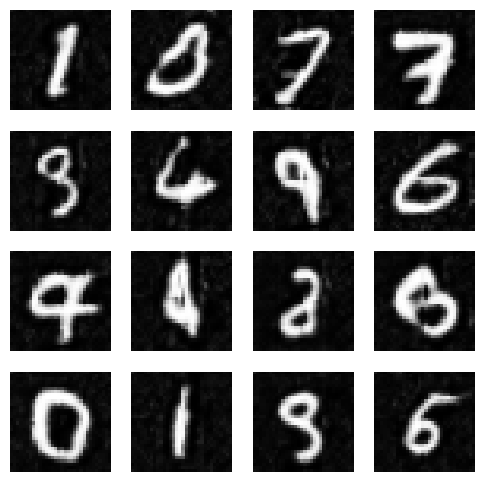

In [11]:
import matplotlib.pyplot as plt

G.eval()
z = torch.randn(16, latent_dim, 1, 1).to(device)

with torch.no_grad():
    fake_imgs = G(z).cpu()

# print(fake_imgs.shape) # torch.Size([16, 1, 28, 28])
# plt.imshow(fake_imgs[0].squeeze())

fake_imgs = (fake_imgs + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_imgs[i][0], cmap="gray")
    ax.axis("off")

plt.show()